In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('sentiment.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10392 entries, 0 to 10391
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   posts      10391 non-null  object
 1   predicted  10392 non-null  object
 2   intensity  10392 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 243.7+ KB


In [ ]:
df.isnull().sum()

,0
posts,1
predicted,0
intensity,0


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.head()

,posts,predicted,intensity
0,I know as parent of child with down syndrome t...,negative,-1
1,but in my heart I know this is the future prom...,neutral,0
2,I have mylefibrosis which turn to leukemia the...,negative,-1
3,from one of my health group subject wayne dyer...,neutral,0
4,gmos now link to leukemia http nsnbc I 2013 07...,neutral,0


<Axes: xlabel='intensity'>

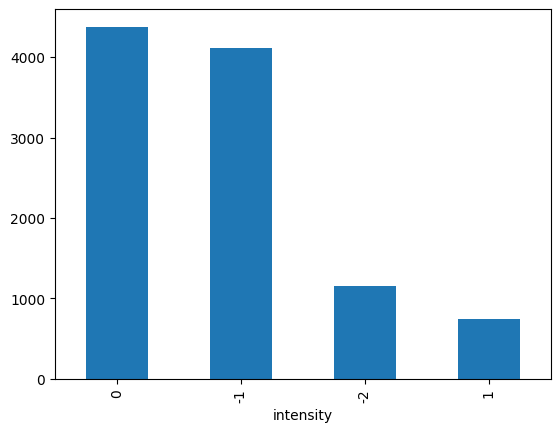

In [ ]:
import matplotlib.pyplot as plt

df['intensity'].value_counts().plot(kind='bar')

In [ ]:
df.shape

(10391, 3)

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# download nltk corpus (first time only)
import nltk

nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For stop words
nltk.download('vader_lexicon')  # For sentiment analysis (if you're using VADER)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# create preprocess_text function
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

df['posts'] = df['posts'].apply(preprocess_text)
df

,posts,predicted,intensity
0,know parent child syndrome hear child high ris...,negative,-1
1,heart know future promise article regardless h...,neutral,0
2,mylefibrosis turn leukemia want stem cell tran...,negative,-1
3,one health group subject wayne dyer leukemia c...,neutral,0
4,gmos link leukemia http nsnbc 2013 07 17 gmo l...,neutral,0
...,...,...,...
10387,hey everyone 25 year old male work eat pretty ...,negative,-1
10388,surgery stage 1 colon cancer 1 year ago cea le...,very negative,-2
10389,doctor advise could remove abnormal polyp chri...,neutral,0
10390,66 year old father much past year really need ...,neutral,0


In [ ]:
# Assuming df['intensity'] has the values -2, -1, 0, 1

# Replace the values
df['intensity'] = df['intensity'].replace({-2: 0, -1: 1, 0: 2, 1: 3})

# Verify the change
print(df['intensity'].head())

0    1
1    2
2    1
3    2
4    2
Name: intensity, dtype: int64


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import joblib

X = df['posts']
y = df['intensity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

joblib.dump(vectorizer, "vectorizer.joblib")

y_test.unique()

array([2, 0, 1, 3])

In [ ]:
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler

X_resampled, y_resampled = RandomUnderSampler().fit_resample(X_train_vec, y_train)

model_lr = LogisticRegression(multi_class='ovr', solver='liblinear')
model_lr.fit(X_resampled, y_resampled)

y_pred = model_lr.predict(X_test_vec)

joblib.dump(model_lr, "sentiment.joblib")

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.85      0.67       246
           1       0.71      0.55      0.62       811
           2       0.80      0.70      0.75       889
           3       0.33      0.71      0.45       133

    accuracy                           0.66      2079
   macro avg       0.60      0.70      0.62      2079
weighted avg       0.71      0.66      0.67      2079



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
text = "Everything seems to be falling apart lately. No matter what I try, nothing works out the way I hope. The weather is gloomy, and it only reflects how I feel inside. People around me seem indifferent, and I can’t shake the feeling that I’m alone in all of this. The constant pressure and disappointment are exhausting, and I find myself questioning if things will ever improve. It feels like I'm stuck in a cycle of negativity, where every effort is met with failure. Even the simplest tasks have become overwhelming, and I'm struggling to see any light at the end of the tunnel."
processed_text = preprocess_text(text)

text_vector = vectorizer.transform([processed_text])
print(model_lr.predict(text_vector))

[0]


In [ ]:
import pickle

with open('sentiment_lr.pkl', 'wb') as model_file:
  pickle.dump(model_lr, model_file)

with open('vectorizer.pkl', 'wb') as vectorizer_file:
  pickle.dump(vectorizer, vectorizer_file)

In [ ]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.5.2
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License
        
        Copyright (c) 2007-2024 The scikit-learn developers.
        All rights reserved.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions are met:
        
        * Redistributions of source code must retain the above copyright notice, this
          list of conditions and the following disclaimer.
        
        * Redistributions in binary form must reproduce the above copyright notice,
          this list of conditions and the following disclaimer in the documentation
          and/or other materials provided with the distribution.
        
        * Neither the name of the copyright holder nor the names of its
          contributors may be used to endorse or promote produ

In [ ]:
!pip show nltk

Name: nltk
Version: 3.9.1
Summary: Natural Language Toolkit
Home-page: https://www.nltk.org/
Author: NLTK Team
Author-email: nltk.team@gmail.com
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: click, joblib, regex, tqdm
Required-by: textblob


In [ ]:
!pip show joblib

Name: joblib
Version: 1.4.2
Summary: Lightweight pipelining with Python functions
Home-page: https://joblib.readthedocs.io
Author: 
Author-email: Gael Varoquaux <gael.varoquaux@normalesup.org>
License: BSD 3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: imbalanced-learn, librosa, mlxtend, music21, nltk, scikit-learn


In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip show imblearn

In [ ]:
!pip freeze > requirements.txt